# Final Notebook Cleaned

# Importing Appropriate Libraries

In [30]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn import tree
import pandas as pd
from sklearn.metrics import classification_report

# Reading In The CSV

In [2]:
df = pd.read_csv('./Fraud.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# Drop Columns I Do Not Need

In [4]:
# The following columns were deemed irrelevant to creating our machines intelligence. 
df.drop(['step','nameOrig','nameDest','isFlaggedFraud'], axis=1, inplace=True)

In [5]:
df.head(1)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0


# Prepare X_train, X_test, y_train, y_test

In [6]:
# All variables but the target are designated to our X value
X = df.drop("isFraud", axis=1)

In [7]:
#Our Target Variable is assigned
y = df['isFraud']

In [10]:
#Splitting the data 80/20
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [11]:
#Sanity check to make sure our train sets have the appropriate amount of samples
y_train.shape

(5090096,)

# Encoder Helper Function For Our Categorical Variable

In [67]:
"""
This is extremely useful for fitting our Train and transforming our test
"""

'\nThis is extremely useful for fitting our Train and transforming our test\n'

In [12]:
def encode_and_concat_feature_train(X_train, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

In [13]:
def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=X.index)
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [16]:
encode_and_concat_feature_train(X_train, 'type')

(OneHotEncoder(handle_unknown='ignore'),
              amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
 3299269  1032330.37       11540.00            0.00       384699.21   
 6223342     6950.31       22027.00        15076.69      6753752.55   
 1435280   274344.90      536260.11       810605.01       559008.94   
 65323      42973.90       11471.00            0.00        31540.24   
 989600     82557.83       69727.00            0.00      2888418.97   
 ...             ...            ...             ...             ...   
 6068313   104976.92           0.00            0.00       239888.93   
 3908034   158615.71       25213.46            0.00       306468.40   
 2079694     6748.18           0.00            0.00            0.00   
 1876519    69806.60           0.00            0.00      1078345.17   
 3557134   388730.62         148.00       388878.62            0.00   
 
          newbalanceDest  CASH_IN  CASH_OUT  DEBIT  PAYMENT  TRANSFER  
 3299269      1417029.58      0.0

In [17]:
# encoding our X_train and fitting it
encoders = {}
categorical_values = ['type']
for categorical_feature in categorical_values:
    ohe, X_train = encode_and_concat_feature_train(X_train, categorical_feature)
    encoders[categorical_feature] = ohe

#Used to transform our whole test set. I will Not do this now but when needed instead. 
X_test = encode_and_concat_feature(X_test,'type', ohe)

# Smote To Give Power To Our Minority Class

In [18]:
# Giving the minority class more representation so our machine can gather it's intelligence based off of 
#synthesized entries that replicate the pattern of our Fradulent Case. 
sm = SMOTE(random_state=42, sampling_strategy=.2)

In [19]:
#Applying the Smote data ONLY to our train sets 
X_train, y_train = sm.fit_resample(X_train, y_train)

# Dummy Model As a Baseline

In [32]:
#This will act as a baseline model in which we will create models that can beat it's different scores
dummy_model_pipe = Pipeline(steps=[
    
    ('dum', DummyClassifier(strategy='most_frequent'))
])

dummy_model_pipe.fit(X_train,y_train)

dummy_model_pipe.predict(encode_and_concat_feature(X_test, 'type', ohe))

dummy_model_pipe.score(X_test, y_test)

dummy_model_pipe.score(X_train, y_train)

print(classification_report(y_test,dummy_model_pipe.predict(encode_and_concat_feature(X_test, 'type', ohe))))

/Users/abdulrahmanamer/opt/anaconda3/envs/brother_rocks_workflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abdulrahmanamer/opt/anaconda3/envs/brother_rocks_workflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270956
           1       0.00      0.00      0.00      1568

    accuracy                           1.00   1272524
   macro avg       0.50      0.50      0.50   1272524
weighted avg       1.00      1.00      1.00   1272524



/Users/abdulrahmanamer/opt/anaconda3/envs/brother_rocks_workflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/abdulrahmanamer/opt/anaconda3/envs/brother_rocks_workflow/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


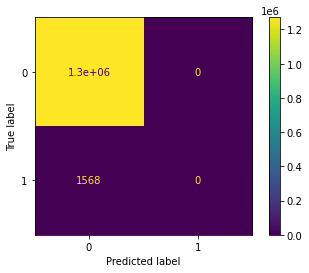

In [89]:
#The below will display how terrible our baseline is. It can detect 0 Fraudulent activity as of now. 
plot_confusion_matrix(dummy_model_pipe, X_test,y_test)

# LOGREG!! How Does It Look?

In [34]:
# Insight into this model...
logreg_model_pipe = Pipeline(steps=[
    
    ('logreg', LogisticRegression(random_state=42))
])

logreg_model_pipe.fit(X_train,y_train)

logreg_model_pipe.predict(encode_and_concat_feature(X_test, 'type', ohe))

logreg_model_pipe.score(encode_and_concat_feature(X_test, 'type', ohe), y_test)

logreg_model_pipe.score(X_train, y_train)

print(classification_report(y_test,logreg_model_pipe.predict(encode_and_concat_feature(X_test, 'type', ohe))))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95   1270956
           1       0.01      0.96      0.02      1568

    accuracy                           0.90   1272524
   macro avg       0.51      0.93      0.49   1272524
weighted avg       1.00      0.90      0.95   1272524



Not so good...I think we can do better.

# RFC! Is It Better?

In [35]:
rfc_model_pipe = Pipeline(steps=[
    
    ('rfc', RandomForestClassifier(random_state=42, n_estimators=1))
])

rfc_model_pipe.fit(X_train,y_train)

rfc_model_pipe.predict(encode_and_concat_feature(X_test, 'type', ohe))

print(rfc_model_pipe.score(encode_and_concat_feature(X_test, 'type', ohe), y_test))

print(rfc_model_pipe.score(X_train, y_train))

print(classification_report(y_test,rfc_model_pipe.predict(encode_and_concat_feature(X_test, 'type', ohe))))

0.9989846949841418
0.9995459121354736
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270956
           1       0.55      0.95      0.70      1568

    accuracy                           1.00   1272524
   macro avg       0.78      0.97      0.85   1272524
weighted avg       1.00      1.00      1.00   1272524



Well that's actually a significant difference. Loving the f1 score.

# DecisionTree!!

In [36]:
DT_model_pipe = Pipeline(steps=[
    
    ('DT', tree.DecisionTreeClassifier())
])

DT_model_pipe.fit(X_train,y_train)

DT_model_pipe.predict(encode_and_concat_feature(X_test, 'type', ohe))

print(DT_model_pipe.score(encode_and_concat_feature(X_test, 'type', ohe), y_test))

print(DT_model_pipe.score(X_train, y_train))

print(classification_report(y_test,DT_model_pipe.predict(encode_and_concat_feature(X_test, 'type', ohe))))

0.9995418553991909
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270956
           1       0.74      0.98      0.84      1568

    accuracy                           1.00   1272524
   macro avg       0.87      0.99      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524



I think this will be the king model!

# OUR WINNERS!!! DECISION TREE VS RANDOMFORESTCLASSIFIER

Lets tune both of these things

Set our paramters and run a grid search for RFC

In [37]:
params_rfc = {}
params_rfc['rfc__criterion'] = ['gini', 'entropy', 'log_loss']
params_rfc['rfc__min_samples_leaf'] = [1,5,10]
params_rfc['rfc__n_estimators'] = [1, 5, 10]

In [39]:
gs_rfc = GridSearchCV(rfc_model_pipe,params_rfc, cv=10, verbose=2)

In [40]:
gs_rfc.fit(X_train,y_train)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
[CV] END rfc__criterion=gini, rfc__min_samples_leaf=1, rfc__n_estimators=1; total time=  10.8s
[CV] END rfc__criterion=gini, rfc__min_samples_leaf=1, rfc__n_estimators=1; total time=  10.4s
[CV] END rfc__criterion=gini, rfc__min_samples_leaf=1, rfc__n_estimators=1; total time=  10.0s
[CV] END rfc__criterion=gini, rfc__min_samples_leaf=1, rfc__n_estimators=1; total time=  10.3s
[CV] END rfc__criterion=gini, rfc__min_samples_leaf=1, rfc__n_estimators=1; total time=   9.7s
[CV] END rfc__criterion=gini, rfc__min_samples_leaf=1, rfc__n_estimators=1; total time=  10.2s
[CV] END rfc__criterion=gini, rfc__min_samples_leaf=1, rfc__n_estimators=1; total time=   9.9s
[CV] END rfc__criterion=gini, rfc__min_samples_leaf=1, rfc__n_estimators=1; total time=  10.3s
[CV] END rfc__criterion=gini, rfc__min_samples_leaf=1, rfc__n_estimators=1; total time=  10.7s
[CV] END rfc__criterion=gini, rfc__min_samples_leaf=1, rfc__n_estimators=1; total 

[CV] END rfc__criterion=gini, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.5min
[CV] END rfc__criterion=gini, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.6min
[CV] END rfc__criterion=gini, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.5min
[CV] END rfc__criterion=gini, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.5min
[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=1, rfc__n_estimators=1; total time=  10.4s
[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=1, rfc__n_estimators=1; total time=  11.2s
[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=1, rfc__n_estimators=1; total time=  10.2s
[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=1, rfc__n_estimators=1; total time=  11.1s
[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=1, rfc__n_estimators=1; total time=  10.8s
[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=1, rfc__n_estimators=1; total time=  10.9s
[CV] END rfc__criterion=

[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.6min
[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.6min
[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.6min
[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.6min
[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.6min
[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.6min
[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.6min
[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.6min
[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.6min
[CV] END rfc__criterion=entropy, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.6min


[CV] END rfc__criterion=log_loss, rfc__min_samples_leaf=10, rfc__n_estimators=5; total time=  55.3s
[CV] END rfc__criterion=log_loss, rfc__min_samples_leaf=10, rfc__n_estimators=5; total time=  56.1s
[CV] END rfc__criterion=log_loss, rfc__min_samples_leaf=10, rfc__n_estimators=5; total time=  56.1s
[CV] END rfc__criterion=log_loss, rfc__min_samples_leaf=10, rfc__n_estimators=5; total time=  51.5s
[CV] END rfc__criterion=log_loss, rfc__min_samples_leaf=10, rfc__n_estimators=5; total time=  52.9s
[CV] END rfc__criterion=log_loss, rfc__min_samples_leaf=10, rfc__n_estimators=5; total time=  52.3s
[CV] END rfc__criterion=log_loss, rfc__min_samples_leaf=10, rfc__n_estimators=5; total time=  54.2s
[CV] END rfc__criterion=log_loss, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.7min
[CV] END rfc__criterion=log_loss, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.7min
[CV] END rfc__criterion=log_loss, rfc__min_samples_leaf=10, rfc__n_estimators=10; total time= 1.7m

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('rfc',
                                        RandomForestClassifier(n_estimators=1,
                                                               random_state=42))]),
             param_grid={'rfc__criterion': ['gini', 'entropy', 'log_loss'],
                         'rfc__min_samples_leaf': [1, 5, 10],
                         'rfc__n_estimators': [1, 5, 10]},
             verbose=2)

In [41]:
gs_rfc.best_estimator_

Pipeline(steps=[('rfc',
                 RandomForestClassifier(criterion='entropy', n_estimators=10,
                                        random_state=42))])

In [44]:
gs_rfc.score(encode_and_concat_feature(X_test, 'type', ohe), y_test)

0.9993760432023286

In [45]:
gs_rfc.cv_results_

{'mean_fit_time': array([ 10.20447359,  45.81743603,  93.8845856 ,   9.71108809,
         45.37336264,  91.51089628,  10.25709698,  44.16577668,
         91.49064481,  10.63576946,  48.35098698,  95.74168763,
         10.55998394,  47.7654434 ,  95.45364451,  10.61109536,
         47.40637543,  94.95300794,  10.51610057,  47.96732175,
         95.641798  ,  10.51155586,  47.28017874, 102.65818875,
         11.72530065,  54.17091904, 103.19538321]),
 'std_fit_time': array([0.3455918 , 1.36019586, 1.7006415 , 0.4266019 , 1.32024959,
        1.09671067, 0.2206403 , 0.80985283, 2.61242249, 0.54987029,
        1.42657933, 2.4296129 , 0.40837142, 1.3158283 , 1.7409855 ,
        0.33521996, 1.10979702, 1.37168506, 0.50466732, 1.47415732,
        2.26631888, 0.37528292, 0.85236122, 3.2447548 , 0.50419932,
        2.2655141 , 2.65690313]),
 'mean_score_time': array([0.10700002, 0.2836441 , 0.4767242 , 0.09988375, 0.28180749,
        0.478441  , 0.10607347, 0.28323102, 0.46391232, 0.10513661,
  

In [46]:
gs_rfc.best_score_

0.9993754242764732

In [47]:
gs_rfc.error_score

nan

In [48]:
gs_rfc.best_params_

{'rfc__criterion': 'entropy',
 'rfc__min_samples_leaf': 1,
 'rfc__n_estimators': 10}

In [49]:
rfc_model_pipe_new = Pipeline(steps=[
    
    ('rfc', RandomForestClassifier(random_state=42, n_estimators=10, min_samples_leaf=1, criterion='entropy'))
])

rfc_model_pipe_new.fit(X_train,y_train)

rfc_model_pipe_new.predict(encode_and_concat_feature(X_test, 'type', ohe))

print(rfc_model_pipe_new.score(encode_and_concat_feature(X_test, 'type', ohe), y_test))

print(rfc_model_pipe_new.score(X_train, y_train))

print(classification_report(y_test,rfc_model_pipe_new.predict(encode_and_concat_feature(X_test, 'type', ohe))))

0.9989846949841418
0.9995459121354736
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270956
           1       0.55      0.95      0.70      1568

    accuracy                           1.00   1272524
   macro avg       0.78      0.97      0.85   1272524
weighted avg       1.00      1.00      1.00   1272524



So it performed like our original...but hey. NOT BAD!

Replicate for Decision Tree Classifier 

In [50]:
params_DT = {}
params_DT['DT__criterion'] = ['gini', 'entropy']
params_DT['DT__min_samples_leaf'] = [1,5,10]
params_DT['DT__max_depth'] = [None, 5, 10]

In [51]:
gs_DT = GridSearchCV(DT_model_pipe,params_DT, cv=10, verbose=2)

In [52]:
gs_DT.fit(X_train,y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV] END DT__criterion=gini, DT__max_depth=None, DT__min_samples_leaf=1; total time=  30.3s
[CV] END DT__criterion=gini, DT__max_depth=None, DT__min_samples_leaf=1; total time=  32.4s
[CV] END DT__criterion=gini, DT__max_depth=None, DT__min_samples_leaf=1; total time=  31.7s
[CV] END DT__criterion=gini, DT__max_depth=None, DT__min_samples_leaf=1; total time=  31.3s
[CV] END DT__criterion=gini, DT__max_depth=None, DT__min_samples_leaf=1; total time=  31.1s
[CV] END DT__criterion=gini, DT__max_depth=None, DT__min_samples_leaf=1; total time=  31.2s
[CV] END DT__criterion=gini, DT__max_depth=None, DT__min_samples_leaf=1; total time=  31.2s
[CV] END DT__criterion=gini, DT__max_depth=None, DT__min_samples_leaf=1; total time=  31.0s
[CV] END DT__criterion=gini, DT__max_depth=None, DT__min_samples_leaf=1; total time=  31.3s
[CV] END DT__criterion=gini, DT__max_depth=None, DT__min_samples_leaf=1; total time=  31.3s
[CV] END DT__crit

[CV] END DT__criterion=entropy, DT__max_depth=None, DT__min_samples_leaf=1; total time=  30.3s
[CV] END DT__criterion=entropy, DT__max_depth=None, DT__min_samples_leaf=1; total time=  32.9s
[CV] END DT__criterion=entropy, DT__max_depth=None, DT__min_samples_leaf=1; total time=  32.8s
[CV] END DT__criterion=entropy, DT__max_depth=None, DT__min_samples_leaf=1; total time=  32.3s
[CV] END DT__criterion=entropy, DT__max_depth=None, DT__min_samples_leaf=1; total time=  32.6s
[CV] END DT__criterion=entropy, DT__max_depth=None, DT__min_samples_leaf=1; total time=  32.6s
[CV] END DT__criterion=entropy, DT__max_depth=None, DT__min_samples_leaf=1; total time=  32.9s
[CV] END DT__criterion=entropy, DT__max_depth=None, DT__min_samples_leaf=1; total time=  32.9s
[CV] END DT__criterion=entropy, DT__max_depth=None, DT__min_samples_leaf=1; total time=  33.0s
[CV] END DT__criterion=entropy, DT__max_depth=None, DT__min_samples_leaf=1; total time=  32.6s
[CV] END DT__criterion=entropy, DT__max_depth=None

[CV] END DT__criterion=entropy, DT__max_depth=10, DT__min_samples_leaf=10; total time=  30.6s
[CV] END DT__criterion=entropy, DT__max_depth=10, DT__min_samples_leaf=10; total time=  30.9s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('DT', DecisionTreeClassifier())]),
             param_grid={'DT__criterion': ['gini', 'entropy'],
                         'DT__max_depth': [None, 5, 10],
                         'DT__min_samples_leaf': [1, 5, 10]},
             verbose=2)

In [53]:
gs_DT.best_params_

{'DT__criterion': 'entropy', 'DT__max_depth': None, 'DT__min_samples_leaf': 1}

In [54]:
gs_rfc.cv_results_

{'mean_fit_time': array([ 10.20447359,  45.81743603,  93.8845856 ,   9.71108809,
         45.37336264,  91.51089628,  10.25709698,  44.16577668,
         91.49064481,  10.63576946,  48.35098698,  95.74168763,
         10.55998394,  47.7654434 ,  95.45364451,  10.61109536,
         47.40637543,  94.95300794,  10.51610057,  47.96732175,
         95.641798  ,  10.51155586,  47.28017874, 102.65818875,
         11.72530065,  54.17091904, 103.19538321]),
 'std_fit_time': array([0.3455918 , 1.36019586, 1.7006415 , 0.4266019 , 1.32024959,
        1.09671067, 0.2206403 , 0.80985283, 2.61242249, 0.54987029,
        1.42657933, 2.4296129 , 0.40837142, 1.3158283 , 1.7409855 ,
        0.33521996, 1.10979702, 1.37168506, 0.50466732, 1.47415732,
        2.26631888, 0.37528292, 0.85236122, 3.2447548 , 0.50419932,
        2.2655141 , 2.65690313]),
 'mean_score_time': array([0.10700002, 0.2836441 , 0.4767242 , 0.09988375, 0.28180749,
        0.478441  , 0.10607347, 0.28323102, 0.46391232, 0.10513661,
  

In [55]:
gs_rfc.best_score_

0.9993754242764732

In [56]:
gs_DT.score(encode_and_concat_feature(X_test, 'type', ohe), y_test)

0.9995638589134664

In [60]:
DT_model_pipe_new = Pipeline(steps=[
    
    ('DT', tree.DecisionTreeClassifier(random_state=42, min_samples_leaf=1, criterion='entropy'))
])

DT_model_pipe_new.fit(X_train,y_train)

DT_model_pipe_new.predict(encode_and_concat_feature(X_test, 'type', ohe))

print(DT_model_pipe_new.score(encode_and_concat_feature(X_test, 'type', ohe), y_test))

print(DT_model_pipe_new.score(X_train, y_train))

print(classification_report(y_test,DT_model_pipe_new.predict(encode_and_concat_feature(X_test, 'type', ohe))))

0.9995512854767375
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270956
           1       0.74      0.99      0.84      1568

    accuracy                           1.00   1272524
   macro avg       0.87      0.99      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524



Similar situation here...BUT STILL BEATS OUR DUMMY AND RFC!!

# SUMMARY!!!

# Our Final Model Will Be The Decision Tree Classifier

# Scores (for Engineer)

In [61]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, DT_model_pipe_new.predict(encode_and_concat_feature(X_test, 'type', ohe))), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, DT_model_pipe_new.predict(encode_and_concat_feature(X_test, 'type', ohe))), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, DT_model_pipe_new.predict(encode_and_concat_feature(X_test, 'type', ohe))), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, DT_model_pipe_new.predict(encode_and_concat_feature(X_test, 'type', ohe))), 2)}.
""")


Our final model's accuracy on the test set is 1.0. 

Our final model's recall on the test set is 0.99 

Our final model's precision on the test set is 0.74 

Our final model's f1-score on the test is 0.84.



# Insights for stakeholder

The below confusion matrix is a beautiful representation of how this classifier does the job very efficiently.

Upper Left Corner - Classified as not fraud and was not fraud! 

Upper Right Corner - Classified as fraud but wasn't fraud!

Lower left corner - Classified as not fraud but was fraud! 

Lower Right Corner - Classified as fraud and was fraud!

First, Detecting non-fraudulent behavior and fraud behaviors are great.

False positive rate is actually useful because in this case, it is better to receive a message "Is this transaction a transaction initalized by you?" then to not be notified at all. 

False negatives are only 1% of all fraud! Which is great, because at the very least, our cases that must be investigated further in this department are extremely decreased and will allow time to go into these cases manually while the other fradulent cases are automated. 

/Users/abdulrahmanamer/opt/anaconda3/envs/brother_rocks_workflow/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


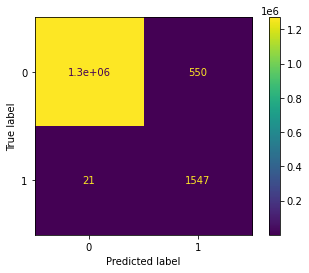

In [64]:
plot_confusion_matrix(DT_model_pipe_new,encode_and_concat_feature(X_test, 'type', ohe), y_test)

# Generating a Tool to Connect New Entries to an Efficient and Accurate Model 

In [80]:
def fraudOrNotFraud():
    typee = input('Transaction type - CASH_OUT, PAYMENT,CASH_IN,TRANSFER,OR DEBIT?: ')
    amount = float(input('Account amount?: '))
    oldbalanceOrg = float(input('Original Balance Before Transaction?: '))
    newbalanceOrig = float(input('New Balance after transaction: '))
    oldbalanceDest = float(input('Balance of receiving account before transaction: '))
    newbalanceDest = float(input('Balance of receiving account after transaction: '))
    
    pred_dict = {
        'type':typee,
        'amount':amount,
        'oldbalanceOrg':oldbalanceOrg,
        'newbalanceOrig':newbalanceOrig,
        'oldbalanceDest':oldbalanceDest,
        'newbalanceDest':newbalanceDest
    }
    x = pd.DataFrame.from_dict(pred_dict,orient='index')
    
    a = DT_model_pipe_new.predict(encode_and_concat_feature(x.T, 'type', ohe))
    
    if a == 0:
        return f'This is not fradulent'
    if a ==1:
        return f'HIGH POTENTIAL OF FRADULENCY. FURTHER ACTION REQUIRED.'
    

# An Example of a Non-Fraudlent Transaction With Our Developed Tool

Do not run this cell unless you are willing to test the model

In [83]:
fraudOrNotFraud()

Transaction type - CASH_OUT, PAYMENT,CASH_IN,TRANSFER,OR DEBIT?: CASH_OUT
Account amount?: 450132
Original Balance Before Transaction?: 75000
New Balance after transaction: 30000
Balance of receiving account before transaction: 874000
Balance of receiving account after transaction: 1450000


'This is not fradulent'

# An Example of a Fradulent Transaction

Do not run this cell unless you are willing to test the model

In [88]:
fraudOrNotFraud()

Transaction type - CASH_OUT, PAYMENT,CASH_IN,TRANSFER,OR DEBIT?: CASH_OUT
Account amount?: 200
Original Balance Before Transaction?: 200
New Balance after transaction: 0
Balance of receiving account before transaction: 23000
Balance of receiving account after transaction: 0


'HIGH POTENTIAL OF FRADULENCY. FURTHER ACTION REQUIRED.'

In [91]:
from sklearn.tree import plot_tree

In [93]:
fm = tree.DecisionTreeClassifier(random_state=42, min_samples_leaf=1, criterion='entropy')

In [94]:
fm.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

# The Mind of The Model - A Visual Representation Of The Decision Tree Classifier


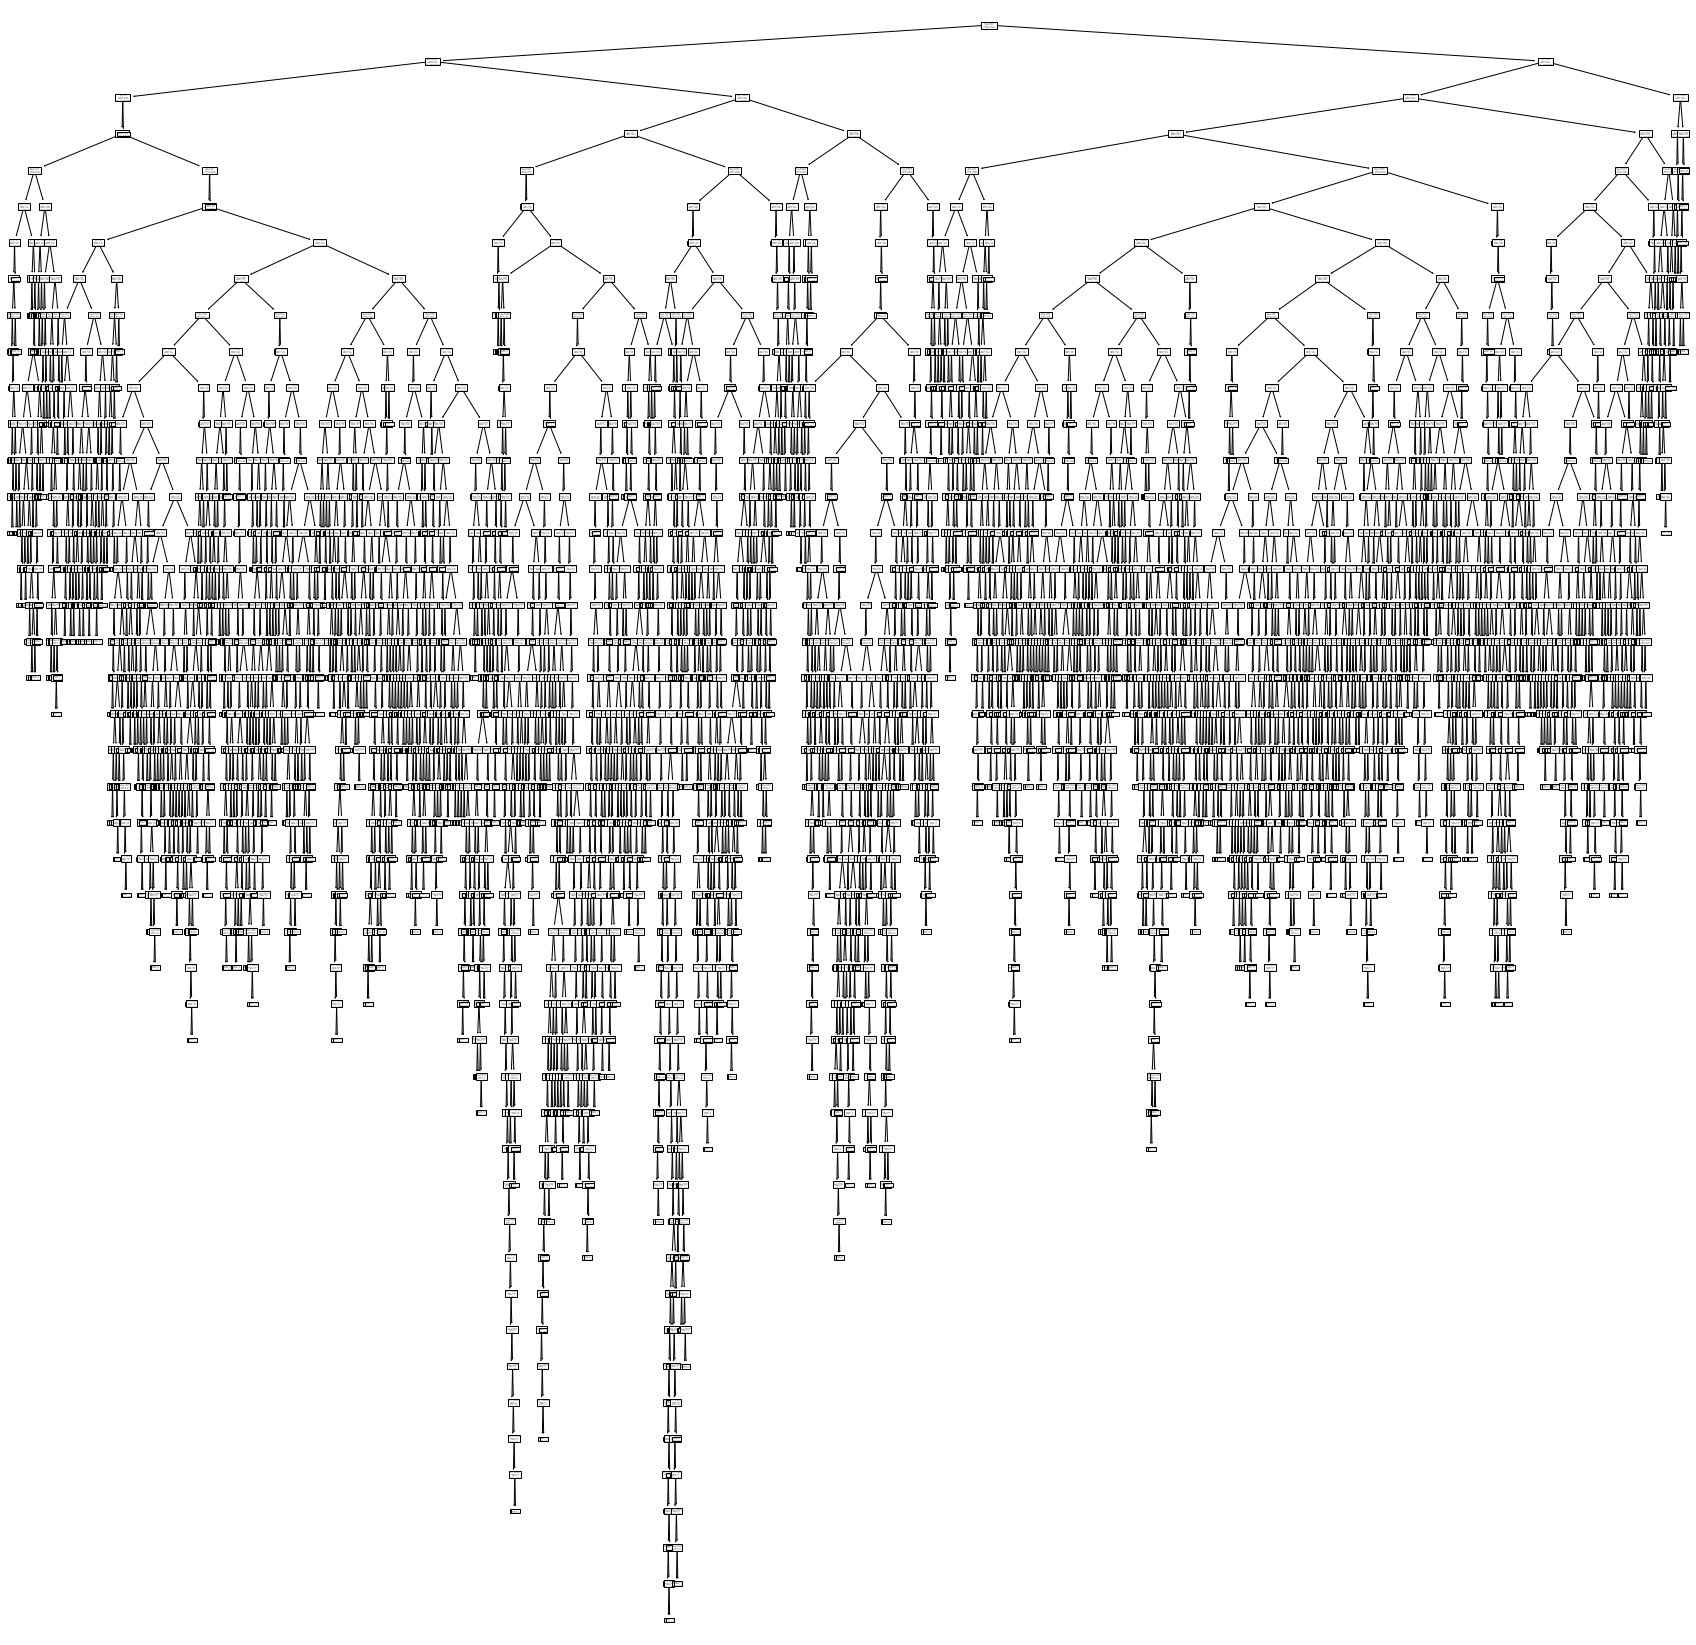

In [96]:
f, ax = plt.subplots(figsize=(30, 30))
plot_tree(fm, ax=ax);